
Transfer Learning for Computer Vision Tutorial
==============================================

In this homework, you will train a CNN using two transfer learning approaches for the same image classification task. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. For deep learning, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

First we will need to download some external resources from GitHub. Run the cell below.


In [8]:

!git clone https://github.com/tcuseniordesign/deep-learning-hw7-2.git

Cloning into 'deep-learning-hw7-2'...
remote: Enumerating objects: 407, done.
remote: Total 407 (delta 0), reused 0 (delta 0), pack-reused 407 (from 1)
Receiving objects: 100% (407/407), 45.03 MiB | 16.46 MiB/s, done.


Then we need to move the resources to the current directory. Run the cell below.

In [11]:
import shutil
import os

source_dir = '/content/deep-learning-hw7-2'
target_dir = '/content/data'

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

os.rmdir('/content/deep-learning-hw7-2')

Error: Destination path '/content/data/.git' already exists

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Let's visualize a few training images so as to understand the data augmentations.



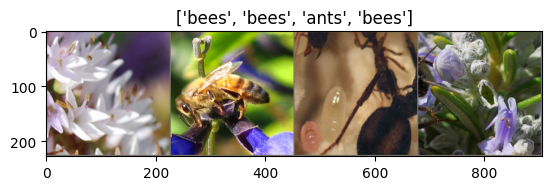

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Generic function to display predictions for a few images




In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Click "Runetime", then click "Change runtime type". Select "GPU" for Hardware accelerator. You can compare the speed between "GPU" and "CPU".

In [16]:
num_classes = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Approach 1: Fine-tuning the CNN
----------------------

Load a pretrained model and reset the final fully connected (FC) layer. Read this section first: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks




In [17]:
model_ft = models.resnet18(pretrained=True) # grab the resnet18 with the trained params from torchvision models
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # some literature calls loss function "criterion"

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4770 Acc: 0.7828
val Loss: 0.1585 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4055 Acc: 0.8238
val Loss: 0.3200 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.5088 Acc: 0.8115
val Loss: 0.2759 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.4456 Acc: 0.8074
val Loss: 0.3041 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.5137 Acc: 0.7910
val Loss: 0.7860 Acc: 0.7778

Epoch 5/24
----------
train Loss: 0.5953 Acc: 0.8074
val Loss: 0.3839 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.4875 Acc: 0.8279
val Loss: 0.3044 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3681 Acc: 0.8607
val Loss: 0.3236 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2683 Acc: 0.8893
val Loss: 0.2623 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.3108 Acc: 0.8566
val Loss: 0.2520 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.3386 Acc: 0.8443
val Loss: 0.2733 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2926 Acc: 0.8730
val Loss: 0.2531 Acc: 0.9020

Ep

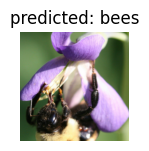

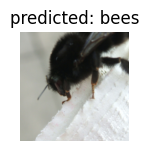

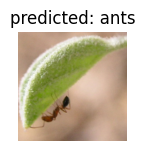

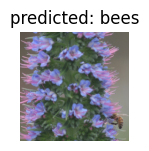

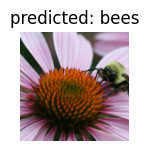

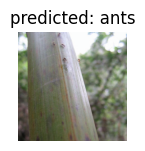

In [19]:
visualize_model(model_ft)

Approach 2: ConvNet as fixed feature extractor
----------------------------------

In this approach, we don't bother retrain the entire CNN. We shall freeze all the  layers from resnet18 except the final one. We just need to train this new final layer. So, we need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    # Freeze all the prams (1 line)
    ### START CODE HERE
    param.requires_grad = False
    ### END CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
# Replace the old final layer with a new final layer (2 lines)
### START CODE HERE
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)

### END CODE HERE
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5461 Acc: 0.6967
val Loss: 0.3088 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4605 Acc: 0.7787
val Loss: 0.1973 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5513 Acc: 0.7828
val Loss: 0.2365 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4121 Acc: 0.8320
val Loss: 0.3066 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4130 Acc: 0.8115
val Loss: 0.2158 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4510 Acc: 0.8156
val Loss: 0.1577 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3776 Acc: 0.8402
val Loss: 0.1733 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3671 Acc: 0.8320
val Loss: 0.1790 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3114 Acc: 0.8607
val Loss: 0.1846 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3274 Acc: 0.8648
val Loss: 0.1711 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3591 Acc: 0.8525
val Loss: 0.3366 Acc: 0.8562

Epoch 11/24
----------
train Loss: 0.2910 Acc: 0.8934
val Loss: 0.2104 Acc: 0.9346

Ep

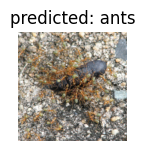

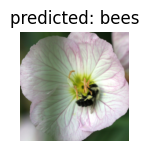

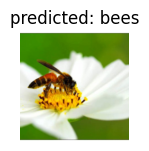

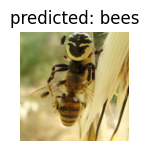

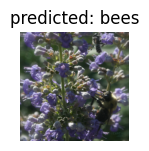

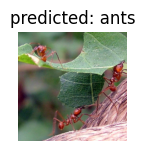

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()